## QuickTest Slim

based on : RankNet-QuickTest-Joint

    makedb laptime
    makedb gluonts
    train model
    evaluate model


In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import random
import mxnet as mx
from mxnet import gluon
import pickle
import json
import copy
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from pathlib import Path
import configparser

from gluonts.model.deepar import DeepAREstimator
from gluonts.model.deep_factor import DeepFactorEstimator
from gluonts.model.deepstate import DeepStateEstimator
from gluonts.trainer import Trainer
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator, MultivariateEvaluator
from gluonts.model.predictor import Predictor
from gluonts.model.prophet import ProphetPredictor
from gluonts.model.r_forecast import RForecastPredictor
from gluonts.dataset.util import to_pandas

from gluonts.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.distribution.student_t import StudentTOutput
from gluonts.distribution.multivariate_gaussian import MultivariateGaussianOutput

from indycar.model.NaivePredictor import NaivePredictor
from indycar.model.deeparw import DeepARWeightEstimator

#import indycar.model.stint_simulator_shortterm_pitmodel as stint
import indycar.model.quicktest_simulator as stint

# import all functions 
#from indycar.model.global_variables import _hi
import indycar.model.global_variables as gvar
from indycar.model.quicktest_modules import *

INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU


## run

In [2]:
WorkRootDir = 'QuickTestOutput'
#reference
#configname = 'weighted-noinlap-nopitage-nocate-c60-drank'
#configname = 'weighted-noinlap-S0LTYP0T-nocate-c60-drank-pitmodel'
configname = 'weighted-noinlap-S0LTYP0T-nocate-c60-drank-oracle'
configfile = f'{configname}.ini'

if configfile != '':
    config = configparser.RawConfigParser()
    config.read(WorkRootDir + '/' + configfile)

    #set them back
    section = "RankNet-QuickTest"
    
    _savedata = config.getboolean(section, "_savedata")
    _skip_overwrite = config.getboolean(section, "_skip_overwrite")
    _inlap_status = config.getint(section, "_inlap_status") #0
    _feature_mode = config.getint(section, "_feature_mode") #FEATURE_STATUS
    _featureCnt = config.getint(section, "_featureCnt") #9
    freq = config.get(section, "freq") #"1min"
    _train_len = config.getint(section, "_train_len") #40
    prediction_length = config.getint(section, "prediction_length") #2
    context_ratio = config.getfloat(section, "context_ratio") #0.
    context_length =  config.getint(section, "context_length") #40
    
    dataset= config.get(section, "dataset") #'rank'
    epochs = config.getint(section, "epochs") #1000
    gpuid = config.getint(section, "gpuid") #5
    _use_weighted_model = config.getboolean(section, "_use_weighted_model")
    trainmodel = config.get(section, "trainmodel") #'deepARW-Oracle' if _use_weighted_model else 'deepAR-Oracle'
    
    _use_cate_feature = config.getboolean(section, "_use_cate_feature")
    
    distroutput = config.get(section, "distroutput") #'student'
    batch_size = config.getint(section, "batch_size") #32
    loopcnt = config.getint(section, "loopcnt") #2
    _test_event = config.get(section, "_test_event") #'Indy500-2018'
    testmodel = config.get(section, "testmodel") #'oracle'
    pitmodel = config.get(section, "pitmodel") #'oracle'
    year = config.get(section, "year") #'2018'
    
    contextlen = context_length
    use_feat_static = _use_cate_feature 

    #config1 = get_config()
    
else:
    print('Warning, please use config file')
    sys.exit(0)

In [3]:
# debug test
#_skip_overwrite = False
dataroot = 'test/'
_debugstr = '-debug'
gpuid = 5
epochs = 1000

# new added parameters
_test_train_len = 40
_joint_train = False
_pitmodel_bias = 0

#_test_event = 'Indy500-2019'
#year = '2019'
#_test_event = 'Phoenix-2018'
#_test_event = 'Texas-2018'
_test_event = 'Gateway-2018'


#year = '2018'
year = _test_event


#shortterm, stint
#_forecast_mode = 'stint'
_forecast_mode = 'shortterm'

# bias of the pitmodel
#_pitmodel_bias = 4

#train model: [deepARW-Oracle, deepAR]

# test the standard deepAR model training and testing

# DeepAR
#trainmodel = 'deepAR'
#testmodel = 'standard'

# Joint 
#trainmodel = 'deepAR-multi'
#testmodel = 'joint'
#_joint_train = True
#loopcnt = 2

# transformer
#trainmodel = 'Transformer-Oracle'
#testmodel = 'Transformer-Oracle'
#trainmodel = 'Transformer'
#testmodel = 'Transformer'
#_joint_train = False
loopcnt = 10



if testmodel == 'pitmodel':
    testmodel = 'pitmodel%s'%(_pitmodel_bias if _pitmodel_bias!=0 else '')

#featurestr = {FEATURE_STATUS:'nopitage',FEATURE_PITAGE:'pitage',FEATURE_LEADERPITCNT:'leaderpitcnt'}
#cur_featurestr = featurestr[_feature_mode]
print('current configfile:', configfile)
cur_featurestr = decode_feature_mode(_feature_mode)
print('feature_mode:', _feature_mode, cur_featurestr)
print('testmodel:', testmodel)
print('pitmodel:', pitmodel)
print('year:', year)
print('test_event:', _test_event)

current configfile: weighted-noinlap-S0LTYP0T-nocate-c60-drank-oracle.ini
FEATURE_STATUS FEATURE_LEADER_PITCNT FEATURE_TOTAL_PITCNT FEATURE_SHIFT_TRACKSTATUS FEATURE_SHIFT_LAPSTATUS FEATURE_SHIFT_TOTAL_PITCNT
feature_mode: 378 S0LTYP0T
testmodel: oracle
pitmodel: oracle
year: Gateway-2018
test_event: Gateway-2018


In [4]:
#
# string map
#
inlapstr = {0:'noinlap',1:'inlap',2:'outlap'}
weightstr = {True:'weighted',False:'noweighted'}
catestr = {True:'cate',False:'nocate'}

#
# input data parameters
#
#events = ['Phoenix','Indy500','Texas','Iowa','Pocono','Gateway']
#events_totalmiles=[256,500,372,268,500,310]
#events_laplen = [1.022,2.5,1.5,0.894,2.5,1.25]
events_info = {
    'Phoenix':(256, 1.022),'Indy500':(500,2.5),'Texas':(372,1.5),
    'Iowa':(268,0.894),'Pocono':(500,2.5),'Gateway':(310,1.25)
}

years = ['2013','2014','2015','2016','2017','2018','2019']
events = [f'Indy500-{x}' for x in years]

events.extend(['Phoenix-2018','Texas-2018','Texas-2019','Pocono-2018','Pocono-2019','Iowa-2018','Iowa-2019',
              'Gateway-2018','Gateway-2019'])

events_id={key:idx for idx, key in enumerate(events)}

#dbid = f'Indy500_{years[0]}_{years[-1]}_v{_featureCnt}_p{_inlap_status}'
dbid = f'IndyCar_d{len(events)}_v{_featureCnt}_p{_inlap_status}'
_dataset_id = '%s-%s'%(inlapstr[_inlap_status], cur_featurestr)


#
# internal parameters
#
distr_outputs ={'student':StudentTOutput(),
                'negbin':NegativeBinomialOutput()
                }
distr_output = distr_outputs[distroutput]

#
#
#
experimentid = f'{weightstr[_use_weighted_model]}-{inlapstr[_inlap_status]}-{cur_featurestr}-{catestr[_use_cate_feature]}-c{context_length}{_debugstr}'

#
#
#
outputRoot = f"{WorkRootDir}/{experimentid}/"
version = f'IndyCar-d{len(events)}'

# standard output file names
LAPTIME_DATASET = f'{outputRoot}/laptime_rank_timediff_pit-oracle-{dbid}.pickle' 
STAGE_DATASET = f'{outputRoot}/stagedata-{dbid}.pickle' 
# year related
SIMULATION_OUTFILE = f'{outputRoot}/{_test_event}/{_forecast_mode}-dfout-{trainmodel}-indy500-{dataset}-{inlapstr[_inlap_status]}-{cur_featurestr}-{testmodel}-l{loopcnt}-alldata.pickle'
EVALUATION_RESULT_DF = f'{outputRoot}/{_test_event}/{_forecast_mode}-evaluation_result_d{dataset}_m{testmodel}.csv'
LONG_FORECASTING_DFS = f'{outputRoot}/{_test_event}/{_forecast_mode}-long_forecasting_dfs_d{dataset}_m{testmodel}.pickle'
FORECAST_FIGS_DIR = f'{outputRoot}/{_test_event}/{_forecast_mode}-forecast-figs-d{dataset}_m{testmodel}/'

In [5]:
# set global vars
gvar._savedata =                            _savedata
gvar._skip_overwrite =                      _skip_overwrite
gvar._inlap_status =                        _inlap_status
gvar._feature_mode =                        _feature_mode
gvar._featureCnt =                          _featureCnt
gvar.freq  =                                freq 
gvar._train_len =                           _train_len
gvar.prediction_length =                    prediction_length
gvar.context_ratio =                        context_ratio
gvar.context_length =                       context_length
gvar.contextlen =                           contextlen
gvar.dataset =                              dataset
gvar.epochs =                               epochs
gvar.gpuid =                                gpuid
gvar._use_weighted_model =                  _use_weighted_model
gvar.trainmodel =                           trainmodel
gvar._use_cate_feature =                    _use_cate_feature
gvar.use_feat_static =                      use_feat_static
gvar.distroutput =                          distroutput
gvar.batch_size =                           batch_size
gvar.loopcnt =                              loopcnt
gvar._test_event =                          _test_event
gvar.testmodel =                            testmodel
gvar.pitmodel =                             pitmodel
gvar.year =                                year
gvar._forecast_mode = _forecast_mode
gvar._test_train_len = _test_train_len
gvar._joint_train = _joint_train
gvar._pitmodel_bias = _pitmodel_bias
gvar.events = events
gvar.events_id  = events_id
gvar.events_info = events_info


gvar.maxlap = get_event_info(_test_event)[2]
gvar.dbid = dbid
gvar.LAPTIME_DATASET = LAPTIME_DATASET

### 1. make laptime dataset

In [6]:
stagedata = {}
global_carids = {}
os.makedirs(outputRoot, exist_ok=True)
os.makedirs(f'{outputRoot}/{_test_event}', exist_ok=True)

#check the dest files first
if _skip_overwrite and os.path.exists(LAPTIME_DATASET) and os.path.exists(STAGE_DATASET):
        #
        # load data
        #
        print('Load laptime and stage dataset:',LAPTIME_DATASET, STAGE_DATASET)
        with open(LAPTIME_DATASET, 'rb') as f:
            global_carids, laptime_data = pickle.load(f, encoding='latin1') 
        with open(STAGE_DATASET, 'rb') as f:
            stagedata = pickle.load(f, encoding='latin1') 
    
else:    
    cur_carid = 0
    for event in events:
        #dataid = f'{event}-{year}'
        #alldata, rankdata, acldata, flagdata
        stagedata[event] = load_data(event)

        alldata, rankdata, acldata, flagdata = stagedata[event]
        carlist = set(acldata['car_number'])
        laplist = set(acldata['completed_laps'])
        print('%s: carno=%d, lapnum=%d'%(event, len(carlist), len(laplist)))

        #build the carid map
        for car in carlist:
            if car not in global_carids:
                global_carids[car] = cur_carid
                cur_carid += 1

    laptime_data = get_laptime_dataset(stagedata, inlap_status = _inlap_status)

    if _savedata:
        import pickle
        #stintdf.to_csv('laptime-%s.csv'%year)
        #savefile = outputRoot + f'laptime_rank_timediff_pit-oracle-{dbid}.pickle' 
        savefile = LAPTIME_DATASET
        print(savefile)
        with open(savefile, 'wb') as f:
            #pack [global_carids, laptime_data]
            savedata = [global_carids, laptime_data]
            # Pickle the 'data' dictionary using the highest protocol available.
            pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

        #savefile = outputRoot + f'stagedata-{dbid}.pickle' 
        savefile = STAGE_DATASET
        print(savefile)
        with open(savefile, 'wb') as f:
            #pack [global_carids, laptime_data]
            savedata = stagedata
            # Pickle the 'data' dictionary using the highest protocol available.
            pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)    
        
#update global var
gvar.global_carids = global_carids

Load laptime and stage dataset: QuickTestOutput/weighted-noinlap-S0LTYP0T-nocate-c60-debug//laptime_rank_timediff_pit-oracle-IndyCar_d16_v9_p0.pickle QuickTestOutput/weighted-noinlap-S0LTYP0T-nocate-c60-debug//stagedata-IndyCar_d16_v9_p0.pickle


### 2. make gluonts db

In [7]:
outdir = outputRoot + _dataset_id
os.makedirs(outdir, exist_ok=True)

if dataset == 'laptime':
    subdir = 'laptime-indy500'
    os.makedirs(f'{outdir}/{subdir}', exist_ok=True)
    _run_ts = COL_LAPTIME
elif dataset == 'timediff':
    subdir = 'timediff-indy500'
    os.makedirs(f'{outdir}/{subdir}', exist_ok=True)
    _run_ts = COL_TIMEDIFF
elif dataset == 'rank':
    subdir = 'rank-indy500'
    os.makedirs(f'{outdir}/{subdir}', exist_ok=True)
    _run_ts = COL_RANK
else:
    print('error, dataset not support: ', dataset)
    
_task_dir = f'{outdir}/{subdir}/'

#
#dbname, train_ds, test_ds = makedbs()   
#
useeid = False
interpolate = False
#ipstr = '-ip' if interpolate else '-noip'
ipstr = '%s-%s'%('ip' if interpolate else 'noip', 'eid' if useeid else 'noeid')
jointstr = '-joint' if _joint_train else ''

dbname = _task_dir + f'gluontsdb-{dataset}-oracle-{ipstr}-all-all-f{freq}-t{prediction_length}-r{_test_event}-indy-{year}{jointstr}.pickle'
laptimedb = _task_dir + f'gluontsdb-{dataset}-oracle-{ipstr}-all-all-f{freq}-t{prediction_length}-r{_test_event}-indy-{year}-newlaptimedata.pickle'

#check the dest files first
if _skip_overwrite and os.path.exists(dbname) and os.path.exists(laptimedb):
        print('Load Gluonts Dataset:',dbname)
        with open(dbname, 'rb') as f:
            freq, prediction_length, cardinality, train_ds, test_ds = pickle.load(f, encoding='latin1') 
        print('.......loaded data, freq=', freq, 'prediction_length=', prediction_length)
        print('Load New Laptime Dataset:',laptimedb)
        with open(laptimedb, 'rb') as f:
            prepared_laptimedata = pickle.load(f, encoding='latin1') 
        
else:
    if useeid:
        cardinality = [len(global_carids), len(laptime_data)]
    else:
        cardinality = [len(global_carids)]

    prepared_laptimedata = prepare_laptimedata(laptime_data,
                           prediction_length, freq, test_event = _test_event,
                           train_ratio=0, context_ratio = 0.,shift_len = prediction_length)

    train_ds, test_ds,_,_ = make_dataset_byevent(prepared_laptimedata, 
                                        prediction_length,freq,
                                         useeid=useeid, run_ts=_run_ts,
                                        test_event=_test_event, log_transform =False,
                                        context_ratio=0, train_ratio = 0, joint_train = _joint_train)    


    if _savedata:
        print('Save Gluonts Dataset:',dbname)
        with open(dbname, 'wb') as f:
            savedata = [freq, prediction_length, cardinality, train_ds, test_ds]
            pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

        print('Save preprocessed laptime Dataset:',laptimedb)
        with open(laptimedb, 'wb') as f:
            pickle.dump(prepared_laptimedata, f, pickle.HIGHEST_PROTOCOL)
        

Load Gluonts Dataset: QuickTestOutput/weighted-noinlap-S0LTYP0T-nocate-c60-debug/noinlap-S0LTYP0T/rank-indy500/gluontsdb-rank-oracle-noip-noeid-all-all-f1min-t2-rGateway-2018-indy-Gateway-2018.pickle
.......loaded data, freq= 1min prediction_length= 2
Load New Laptime Dataset: QuickTestOutput/weighted-noinlap-S0LTYP0T-nocate-c60-debug/noinlap-S0LTYP0T/rank-indy500/gluontsdb-rank-oracle-noip-noeid-all-all-f1min-t2-rGateway-2018-indy-Gateway-2018-newlaptimedata.pickle


### 3. train the model

In [8]:
id='oracle'
run=1
runid=f'{trainmodel}-{dataset}-all-indy-f1min-t{prediction_length}-e{epochs}-r{run}_{id}_t{prediction_length}'
modelfile = _task_dir + runid

if _skip_overwrite and os.path.exists(modelfile):
    print('Model checkpoint found at:',modelfile)

else:
    #get target dim
    entry = next(iter(train_ds))
    target_dim = entry['target'].shape
    target_dim = target_dim[0] if len(target_dim) > 1 else 1
    print('target_dim:%s', target_dim)

    estimator = init_estimator(trainmodel, gpuid, 
            epochs, batch_size,target_dim, distr_output = distr_output,use_feat_static = use_feat_static)

    predictor = estimator.train(train_ds)

    if _savedata:
        os.makedirs(modelfile, exist_ok=True)

        print('Start to save the model to %s', modelfile)
        predictor.serialize(Path(modelfile))
        print('End of saving the model.')



Model checkpoint found at: QuickTestOutput/weighted-noinlap-S0LTYP0T-nocate-c60-debug/noinlap-S0LTYP0T/rank-indy500/deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2



### 4. evaluate the model

In [9]:
lapmode = _inlap_status
fmode = _feature_mode
runts = dataset
mid = f'{testmodel}-%s-%s-%s-%s'%(runts, year, inlapstr[lapmode], cur_featurestr)
datasetid = outputRoot + _dataset_id

if _skip_overwrite and os.path.exists(SIMULATION_OUTFILE):
    print('Load Simulation Results:',SIMULATION_OUTFILE)
    with open(SIMULATION_OUTFILE, 'rb') as f:
        dfs,acc,ret,pret = pickle.load(f, encoding='latin1') 
    print('.......loaded data, ret keys=', ret.keys())
    
    
    # init the stint module
    #
    # in test mode, set all train_len = 40 to unify the evaluation results
    #
    init_simulation(datasetid, _test_event, 'rank',stint.COL_RANK,'rank',prediction_length, 
                    pitmodel=pitmodel, inlapmode=lapmode,featuremode =fmode,
                    train_len = _test_train_len, pitmodel_bias= _pitmodel_bias, prepared_laptimedata = prepared_laptimedata)    

else:
    #run simulation
    acc, ret, pret = {}, {}, {}

    #lapmode = _inlap_status
    #fmode = _feature_mode
    #runts = dataset
    #mid = f'{testmodel}-%s-%s-%s-%s'%(runts, year, inlapstr[lapmode], featurestr[fmode])

    if runts == 'rank':
        acc[mid], ret[mid] = simulation(datasetid, _test_event, 
                    'rank',stint.COL_RANK,'rank',
                   prediction_length, stint.MODE_ORACLE,loopcnt, 
                      pitmodel=pitmodel, model=testmodel, inlapmode=lapmode,featuremode =fmode,
                    train_len = _test_train_len, forecastmode = _forecast_mode, joint_train = _joint_train,
                    pitmodel_bias= _pitmodel_bias, prepared_laptimedata = prepared_laptimedata,
                    epochs = epochs)
    else:
        acc[mid], ret[mid] = simulation(datasetid, _test_event, 
                    'timediff',stint.COL_TIMEDIFF,'timediff2rank',
                   prediction_length, stint.MODE_ORACLE,loopcnt, 
                      pitmodel=pitmodel, model=testmodel, inlapmode=lapmode,featuremode =fmode,
                    train_len = _test_train_len, forecastmode = _forecast_mode, joint_train = _joint_train,
                    pitmodel_bias= _pitmodel_bias, prepared_laptimedata = prepared_laptimedata,
                    epochs = epochs)

    if _forecast_mode == 'shortterm':
        allsamples, alltss = get_allsamples(ret[mid], year=year)
        _, pret[mid]= prisk_direct_bysamples(allsamples, alltss)
        print(pret[mid])
    

    dfs={}

    mode=1
    df = get_alldf_mode(ret[mid], year=year,mode=mode, forecast_mode = _forecast_mode)
    name = '%s_%s'%(testmodel, 'mean' if mode==1 else ('mode' if mode==0 else 'median'))
    if year not in dfs:
        dfs[year] = {}
    dfs[year][name] = df

    _trim = 0
    _include_final = True
    _include_stintlen = True
    include_str = '1' if _include_final else '0'
    stint_str = '1' if _include_stintlen else ''            
    #simulation_outfile=outputRoot + f'shortterm-dfout-oracle-indy500-{dataset}-{inlapstr[_inlap_status]}-{featurestr[_feature_mode]}-2018-oracle-l{loopcnt}-alldata-weighted.pickle'

    with open(SIMULATION_OUTFILE, 'wb') as f:
        savedata = [dfs,acc,ret,pret]
        pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)
        
#alias
ranknetdf = dfs   
ranknet_ret = ret

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_simulator.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_simulator.py:696: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset QuickTestOutput/weighted-noinlap-S0LTYP0T-nocate-c60-debug//laptime_rank_timediff_pit-oracle-IndyCar_d16_v9_p0.pickle with 16 races, 59 cars
Set a new global laptime_data, test_event=Gateway-2018, cnt=15, shape=(20, 15, 248)
predicting model=oracle, plen=2
loading model...deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2...done!, ctx:gpu(0)
sim_init: input laptime_data, shape= 15 (20, 15, 248) 14
sim_init: after laptime_data, shape= 15 (20, 19, 248)
evalbyrank: True
sim_init: input laptime_data, shape= 15 (20, 19, 248) 14
sim_init: after laptime_data, shape= 15 (20, 19, 248)
evalbyrank: True
sim_init: input laptime_data, shape= 15 (20, 19, 248) 14
sim_init: after laptime_data, shape= 15 (20, 19, 248)
evalbyrank: True
sim_init: input laptime_data, shape= 15 (20, 19, 248) 14
sim_init: after laptime_data, shape= 15 (20, 19, 248)
evalbyrank: True
sim_init: input laptime_data, shape= 15 (20, 19, 248) 14
sim_init: after laptime_data, shape= 15 (20, 19, 248)
evalbyra

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:1686: RuntimeWarning: Mean of empty slice
  forecast_mean = np.nanmean(forecast[carno], axis=0)
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:1699: RuntimeWarning: invalid value encountered in less_equal
  * ((target <= quantile_forecast) - q)


df size: 4610


In [10]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


### 5. final evaluation

In [11]:
if _skip_overwrite and os.path.exists(EVALUATION_RESULT_DF):
    print('Load Evaluation Results:',EVALUATION_RESULT_DF)
    oracle_eval_result = pd.read_csv(EVALUATION_RESULT_DF)

else:    
    ##-------------------------------------------------------------------------------
    if _forecast_mode == 'shortterm':

        # get pit laps, pit-covered-laps
        # pitdata[event] = [pitlaps, pitcoveredlaps]
        with open('pitcoveredlaps-alldata-g1.pickle', 'rb') as f:
            # The protocol version used is detected automatically, so we do not
            # have to specify it.
            pitdata = pickle.load(f, encoding='latin1') 

        #
        # Model,SignAcc,MAE,50-Risk,90-Risk
        # 
        cols = ['Year','Model','ExpID','laptype','Top1Acc','MAE','50-Risk','90-Risk']
        plen = prediction_length
        usemeanstr='mean'

        #load data
        # dfs,acc,ret,pret

        retdata = []

        #oracle
        dfx = ret[mid]
        allsamples, alltss = get_allsamples(dfx, year=year)
        #_, pret[mid]= prisk_direct_bysamples(ret[mid][0][1], ret[mid][0][2])
        _, prisk_vals = prisk_direct_bysamples(allsamples, alltss)

        dfout = do_rerank(ranknetdf[year][f'{testmodel}_mean'])
        accret = stint.get_evalret_shortterm(dfout)[0]
        #fsamples, ftss = runs2samples_ex(ranknet_ret[f'oracle-RANK-{year}-inlap-nopitage'],[])
        #_, prisk_vals = prisk_direct_bysamples(fsamples, ftss)
        retdata.append([year,f'{testmodel}',configname,'all', accret[0], accret[1], prisk_vals[1], prisk_vals[2]])

        for laptype in ['normal','pit']:
            # select the set
            pitcoveredlaps = pitdata[_test_event][1]
            normallaps = set([x for x in range(1,201)]) - pitcoveredlaps

            if laptype == 'normal':
                sellaps = normallaps
                clearlaps = pitcoveredlaps
            else:
                sellaps = pitcoveredlaps
                clearlaps = normallaps


            # pitcoveredlaps start idx = 1
            startlaps = [x-plen-1 for x in sellaps]
            #sellapidx = np.array([x-1 for x in sellaps])
            clearidx = np.array([x-1 for x in clearlaps])
            print('sellaps:', len(sellaps), 'clearlaps:',len(clearlaps))

            #oracle
            #outfile=f'shortterm-dfout-ranknet-indy500-rank-inlap-nopitage-20182019-oracle-l10-alldata-weighted.pickle'
            #_all = load_dfout_all(outfile)[0]
            #ranknetdf, acc, ret, pret = _all[0],_all[1],_all[2],_all[3]

            dfout = do_rerank(ranknetdf[year][f'{testmodel}_mean'])

            allsamples, alltss = get_allsamples(dfx, year=year)


            allsamples, alltss = clear_samples(allsamples, alltss,clearidx)

            _, prisk_vals = prisk_direct_bysamples(allsamples, alltss)

            dfout = dfout[dfout['startlap'].isin(startlaps)]
            accret = stint.get_evalret_shortterm(dfout)[0]

            print(year, laptype,f'RankNet-{testmodel}',accret[0], accret[1], prisk_vals[1], prisk_vals[2])
            retdata.append([year, f'{testmodel}',configname,laptype, accret[0], accret[1], prisk_vals[1], prisk_vals[2]])
            
    ##-------------------------------------------------------------------------------
    elif _forecast_mode == 'stint':
        if testmodel == 'oracle':
            #datafile=f'stint-dfout-mlmodels-indy500-tr2013_2017-te2018_2019-end1-oracle-t0-tuned.pickle'
            datafile=f'{dataroot}/stint-dfout-mlmodels-{version}-end1-oracle-t0-tuned.pickle'
        else:
            #datafile=f'stint-dfout-mlmodels-indy500-tr2013_2017-te2018_2019-end1-normal-t0-tuned.pickle'
            datafile=f'{dataroot}/stint-dfout-mlmodels-{version}-end1-normal-t0-tuned.pickle'
        #preddf = load_dfout(outfile)
        with open(datafile, 'rb') as f:
            preddf = pickle.load(f, encoding='latin1')[0] 
        #preddf_oracle = load_dfout(outfile)
        ranknet_ret = ret 

        errlist = {}
        errcnt, errlist[year] = cmp_df(ranknetdf[year][f'{testmodel}_mean'], preddf[year]['lasso'])
        
        retdata = []
        #
        # Model,SignAcc,MAE,50-Risk,90-Risk
        # 
        cols = ['Year','Model','ExpID','laptype','SignAcc','MAE','50-Risk','90-Risk']
        models = {'currank':'CurRank','rf':'RandomForest','svr_lin':'SVM','xgb':'XGBoost'}

        for clf in ['currank','rf','svr_lin','xgb']:
            print('year:',year,'clf:',clf)
            dfout, accret = eval_sync(preddf[year][clf],errlist[year])
            fsamples, ftss = df2samples_ex(dfout)
            _, prisk_vals = prisk_direct_bysamples(fsamples, ftss)

            retdata.append([year,models[clf],configname,'all', accret[0], accret[1], prisk_vals[1], prisk_vals[2]])
            
        #ml models -oracle
        #for clf in ['rf','svr_lin','xgb']:
        #    print('year:',year,'clf:',clf)
        #    dfout, accret = eval_sync(preddf_oracle[year][clf],errlist[year])
        #    fsamples, ftss = df2samples(dfout)
        #    _, prisk_vals = prisk_direct_bysamples(fsamples, ftss)
        #    retdata.append([year,models[clf]+'-Oracle',configname,'all',accret[0], accret[1], prisk_vals[1], prisk_vals[2]])

        dfout, accret = eval_sync(ranknetdf[year][f'{testmodel}_mean'], errlist[year],force2int=True)
        #fsamples, ftss = df2samples(dfout)
        fsamples, ftss = runs2samples(ranknet_ret[mid],errlist[f'{year}'])
        _, prisk_vals = prisk_direct_bysamples(fsamples, ftss)
        retdata.append([year,f'{testmodel}',configname,'all',accret[0], accret[1], prisk_vals[1], prisk_vals[2]])

        #dfout, accret = eval_sync(ranknetdf[year]['oracle_mean'], errlist[year],force2int=True)
        ##fsamples, ftss = df2samples(dfout)
        #fsamples, ftss = runs2samples(ranknet_ret[f'oracle-TIMEDIFF-{year}-noinlap-nopitage'],errlist[f'{year}'])
        #_, prisk_vals = prisk_direct_bysamples(fsamples, ftss)
        #retdata.append([year,'RankNet-Oracle',accret[0], accret[1], prisk_vals[1], prisk_vals[2]])

    oracle_eval_result = pd.DataFrame(data=retdata, columns=cols)
    if _savedata:
        oracle_eval_result.to_csv(EVALUATION_RESULT_DF)    

sacmplecnt: 100 lapcnt: 310 runcnt: 10
dict_values([0.031891562667661945, 0.038342508572628234, 0.03293909351746017])
rerank...
model: acc={0.96}, mae={0.26}, rmse={0.88},r2={0.98}, {236}
            naive: acc={0.92}, mae={0.33}, rmse={1.17},r2={0.96}
sellaps: 129 clearlaps: 97
rerank...
sacmplecnt: 100 lapcnt: 310 runcnt: 10
dict_values([0.013039995389580452, 0.017315391117258334, 0.013406147226064239])
model: acc={0.98}, mae={0.06}, rmse={0.31},r2={1.00}, {120}
            naive: acc={0.99}, mae={0.07}, rmse={0.48},r2={0.99}
Gateway-2018 normal RankNet-oracle 0.9833333333325138 0.055345911949685536 0.017315391117258334 0.013406147226064239
sellaps: 97 clearlaps: 129
rerank...


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:1686: RuntimeWarning: Mean of empty slice
  forecast_mean = np.nanmean(forecast[carno], axis=0)
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:1699: RuntimeWarning: invalid value encountered in less_equal
  * ((target <= quantile_forecast) - q)


sacmplecnt: 100 lapcnt: 310 runcnt: 10
dict_values([0.05468469096983393, 0.0640805247125872, 0.05677174019848679])
model: acc={0.93}, mae={0.56}, rmse={1.34},r2={0.94}, {94}
            naive: acc={0.81}, mae={0.73}, rmse={1.76},r2={0.90}
Gateway-2018 pit RankNet-oracle 0.9255319148926324 0.5603070175438597 0.0640805247125872 0.05677174019848679


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:1686: RuntimeWarning: Mean of empty slice
  forecast_mean = np.nanmean(forecast[carno], axis=0)
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:1699: RuntimeWarning: invalid value encountered in less_equal
  * ((target <= quantile_forecast) - q)


### 6. Draw forecasting results

In [12]:
if _forecast_mode == 'shortterm' and _joint_train == False:
    if _skip_overwrite and os.path.exists(LONG_FORECASTING_DFS):
        fname = LONG_FORECASTING_DFS
        print('Load Long Forecasting Data:',fname)
        with open(fname, 'rb') as f:
            alldata = pickle.load(f, encoding='latin1') 
        print('.......loaded data, alldata keys=', alldata.keys())

    else:    

        oracle_ret = ret    
        mid = f'{testmodel}-%s-%s-%s-%s'%(runts, year, inlapstr[lapmode], cur_featurestr)
        print('eval mid:', mid, f'{testmodel}_ret keys:', ret.keys())

        ## init predictor
        _predictor =  NaivePredictor(freq= freq, prediction_length = prediction_length)

        oracle_dfout = do_rerank(dfs[year][f'{testmodel}_mean'])
        carlist = set(list(oracle_dfout.carno.values))
        carlist = [int(x) for x in carlist]
        print('carlist:', carlist,'len:',len(carlist))

        #carlist = [13, 7, 3, 12]
        #carlist = [13]    

        retdata = {}
        for carno in carlist:
            print("*"*40)
            print('Run models for carno=', carno)
            # create the test_ds first
            test_cars = [carno]

            #train_ds, test_ds, trainset, testset = stint.make_dataset_byevent(events_id[_test_event], 
            #                                 prediction_length,freq, 
            #                                 oracle_mode=stint.MODE_ORACLE,
            #                                 run_ts = _run_ts,
            #                                 test_event = _test_event,
            #                                 test_cars=test_cars,
            #                                 half_moving_win = 0,
            #                                 train_ratio = 0.01)

            train_ds, test_ds, trainset, testset = make_dataset_byevent(prepared_laptimedata, prediction_length,freq,
                                             useeid=useeid, run_ts=_run_ts,
                                            test_event=_test_event, log_transform =False,
                                            context_ratio=0, train_ratio = 0,
                                            joint_train = _joint_train,
                                            test_cars = test_cars)    


            if (len(testset) <= 10 + prediction_length):
                print('ts too short, skip ', len(testset))
                continue

            #by first run samples
            samples = oracle_ret[mid][0][1][test_cars[0]]
            tss  = oracle_ret[mid][0][2][test_cars[0]]
            target_oracle1, tss_oracle1 = long_predict_bysamples('1run-samples', samples, tss, test_ds, _predictor)

            #by first run output df(_use_mean = true, already reranked)
            df = oracle_ret[mid][0][0]
            dfin_oracle = df[df['carno']==test_cars[0]]
            target_oracle2, tss_oracle2 = long_predict_bydf(f'{testmodel}-1run-dfout', dfin_oracle, test_ds, _predictor)        


            #by multi-run mean at oracle_dfout
            df = oracle_dfout
            dfin_oracle = df[df['carno']==test_cars[0]]
            target_oracle3, tss_oracle3 = long_predict_bydf(f'{testmodel}-multimean', dfin_oracle, test_ds, _predictor)        


            #no rerank
            df = ranknetdf[year][f'{testmodel}_mean']
            dfin_oracle = df[df['carno']==test_cars[0]]
            target_oracle4, tss_oracle4 = long_predict_bydf(f'{testmodel}-norerank-multimean', dfin_oracle, test_ds, _predictor)        


            #by multiple runs
            target_oracle_multirun, tss_oracle_multirun = get_ranknet_multirun(
                                    oracle_ret[mid], 
                                    test_cars[0], test_ds, _predictor,sampleCnt=loopcnt)

            retdata[carno] = [[tss_oracle1,tss_oracle2,tss_oracle3,tss_oracle4,tss_oracle_multirun],
                               [target_oracle1,target_oracle2,target_oracle3,target_oracle4,target_oracle_multirun]]

        alldata = retdata    

        if _savedata:
            with open(LONG_FORECASTING_DFS, 'wb') as f:
                pickle.dump(alldata, f, pickle.HIGHEST_PROTOCOL)  
            
           

eval mid: oracle-rank-Gateway-2018-noinlap-S0LTYP0T oracle_ret keys: dict_keys(['oracle-rank-Gateway-2018-noinlap-S0LTYP0T'])
rerank...
carlist: [1, 98, 4, 5, 27, 9, 10, 12, 14, 15, 19, 20, 21, 22, 23, 88, 26, 59, 28, 30] len: 20
****************************************
Run models for carno= 1
after ====event:Indy500-2013, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
carno:1, totallen:200, nancount:0, test_reccnt:0,featureCnt:7
after ====event:Indy500-2014, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
after ====event:Indy500-2015, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
carno:1, totallen:200, nancount:0, test_reccnt:0,featureCnt:7
after ====event:Indy500-2016, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
after ====event:Indy500-2017, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
carno:1, totallen:200, nancount:0, test_reccnt:0,featureCnt:7
after ====even

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/NaivePredictor.py:60: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start_date=start + target_len,


tss len=236, forecasts len=236
11 246
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 237)
tss len=236, forecasts len=236
first start: 11 last start: 246
sampel# x predictlen:  100 2
target samples: (100, 237)
tss len=236, forecasts len=236
first start: 11 last start: 246
sampel# x predictlen:  100 2
target samples: (100, 237)
tss len=236, forecasts len=236
first start: 11 last start: 246
sampel# x predictlen:  100 2
target samples: (100, 237)
dfin_ranknet size: 2360
tss len=236, forecasts len=236
first start: 11 last start: 246
sampel# x predictlen:  10 2
multirun target samples: (10, 237)
****************************************
Run models for carno= 98
after ====event:Indy500-2013, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
carno:98, totallen:196, nancount:4, test_reccnt:0,featureCnt:7
after ====event:Indy500-2014, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
carno:98, totallen:200, nancount:0, t

tss len=234, forecasts len=234
11 244
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 235)
tss len=234, forecasts len=234
first start: 11 last start: 244
sampel# x predictlen:  100 2
target samples: (100, 235)
tss len=234, forecasts len=234
first start: 11 last start: 244
sampel# x predictlen:  100 2
target samples: (100, 235)
tss len=234, forecasts len=234
first start: 11 last start: 244
sampel# x predictlen:  100 2
target samples: (100, 235)
dfin_ranknet size: 2340
tss len=234, forecasts len=234
first start: 11 last start: 244
sampel# x predictlen:  10 2
multirun target samples: (10, 235)
****************************************
Run models for carno= 27
after ====event:Indy500-2013, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
carno:27, totallen:199, nancount:1, test_reccnt:0,featureCnt:7
after ====event:Indy500-2014, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
carno:27, totallen:175, nancount:25, 

tss len=236, forecasts len=236
first start: 11 last start: 246
sampel# x predictlen:  100 2
target samples: (100, 237)
tss len=236, forecasts len=236
first start: 11 last start: 246
sampel# x predictlen:  100 2
target samples: (100, 237)
tss len=236, forecasts len=236
first start: 11 last start: 246
sampel# x predictlen:  100 2
target samples: (100, 237)
dfin_ranknet size: 2360
tss len=236, forecasts len=236
first start: 11 last start: 246
sampel# x predictlen:  10 2
multirun target samples: (10, 237)
****************************************
Run models for carno= 12
after ====event:Indy500-2013, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
carno:12, totallen:200, nancount:0, test_reccnt:0,featureCnt:7
after ====event:Indy500-2014, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
carno:12, totallen:200, nancount:0, test_reccnt:0,featureCnt:7
after ====event:Indy500-2015, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=1

tss len=235, forecasts len=235
first start: 11 last start: 245
sampel# x predictlen:  100 2
target samples: (100, 236)
tss len=235, forecasts len=235
first start: 11 last start: 245
sampel# x predictlen:  100 2
target samples: (100, 236)
tss len=235, forecasts len=235
first start: 11 last start: 245
sampel# x predictlen:  100 2
target samples: (100, 236)
dfin_ranknet size: 2350
tss len=235, forecasts len=235
first start: 11 last start: 245
sampel# x predictlen:  10 2
multirun target samples: (10, 236)
****************************************
Run models for carno= 19
after ====event:Indy500-2013, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
carno:19, totallen:200, nancount:0, test_reccnt:0,featureCnt:7
after ====event:Indy500-2014, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
carno:19, totallen:198, nancount:2, test_reccnt:0,featureCnt:7
after ====event:Indy500-2015, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=1

tss len=236, forecasts len=236
11 246
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 237)
tss len=236, forecasts len=236
first start: 11 last start: 246
sampel# x predictlen:  100 2
target samples: (100, 237)
tss len=236, forecasts len=236
first start: 11 last start: 246
sampel# x predictlen:  100 2
target samples: (100, 237)
tss len=236, forecasts len=236
first start: 11 last start: 246
sampel# x predictlen:  100 2
target samples: (100, 237)
dfin_ranknet size: 2360
tss len=236, forecasts len=236
first start: 11 last start: 246
sampel# x predictlen:  10 2
multirun target samples: (10, 237)
****************************************
Run models for carno= 22
after ====event:Indy500-2013, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
carno:22, totallen:200, nancount:0, test_reccnt:0,featureCnt:7
after ====event:Indy500-2014, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
carno:22, totallen:200, nancount:0, t

tss len=230, forecasts len=230
11 240
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 231)
tss len=230, forecasts len=230
first start: 11 last start: 240
sampel# x predictlen:  100 2
target samples: (100, 231)
tss len=230, forecasts len=230
first start: 11 last start: 240
sampel# x predictlen:  100 2
target samples: (100, 231)
tss len=230, forecasts len=230
first start: 11 last start: 240
sampel# x predictlen:  100 2
target samples: (100, 231)
dfin_ranknet size: 2300
tss len=230, forecasts len=230
first start: 11 last start: 240
sampel# x predictlen:  10 2
multirun target samples: (10, 231)
****************************************
Run models for carno= 26
after ====event:Indy500-2013, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
carno:26, totallen:200, nancount:0, test_reccnt:0,featureCnt:7
after ====event:Indy500-2014, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
carno:26, totallen:200, nancount:0, t

tss len=161, forecasts len=161
first start: 11 last start: 171
sampel# x predictlen:  100 2
target samples: (100, 162)
tss len=161, forecasts len=161
first start: 11 last start: 171
sampel# x predictlen:  100 2
target samples: (100, 162)
tss len=161, forecasts len=161
first start: 11 last start: 171
sampel# x predictlen:  100 2
target samples: (100, 162)
dfin_ranknet size: 1610
tss len=161, forecasts len=161
first start: 11 last start: 171
sampel# x predictlen:  10 2
multirun target samples: (10, 162)
****************************************
Run models for carno= 30
after ====event:Indy500-2013, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
after ====event:Indy500-2014, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
after ====event:Indy500-2015, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
after ====event:Indy500-2016, prediction_len=2,train_len=60, max_len=200, min_len=200,context_len=10
after ====event:Indy500

(array([ 58, 119, 176, 237]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)
xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


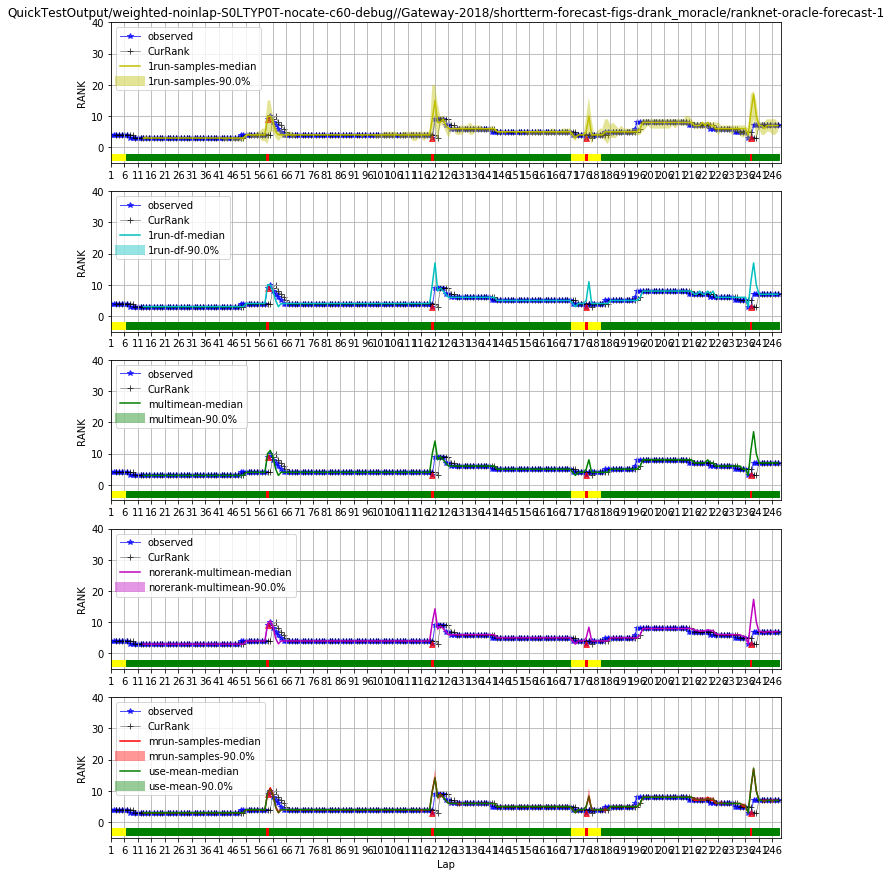

(array([ 56, 112, 167, 213]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)
xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


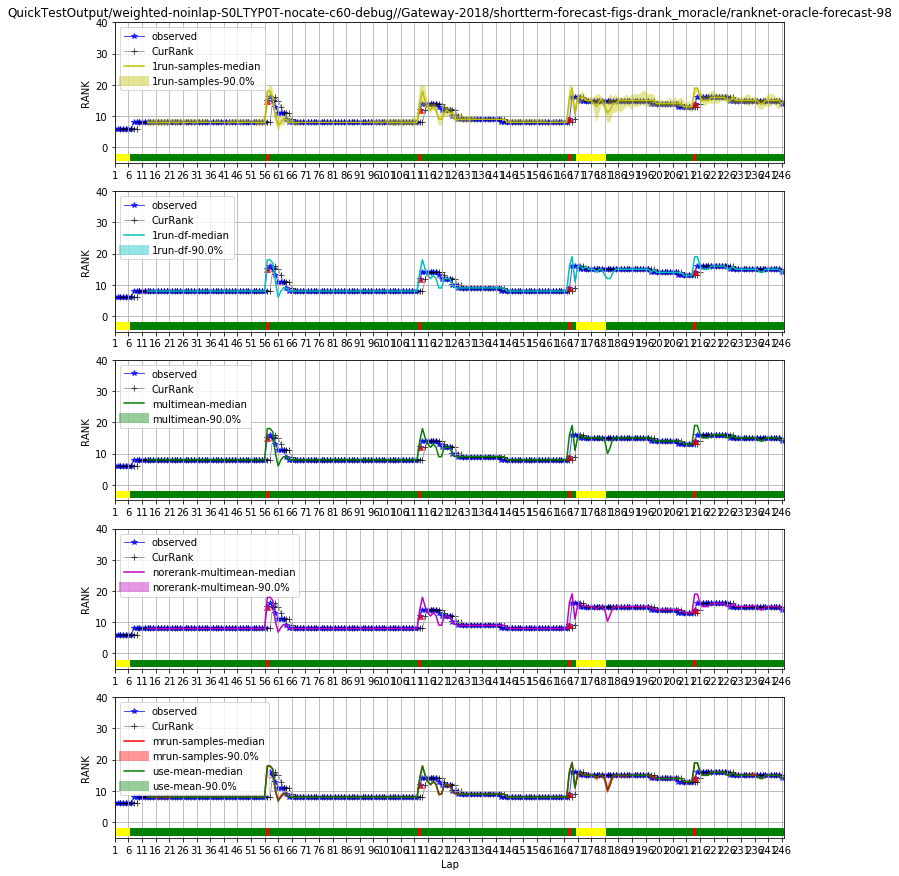

(array([ 57, 112, 169, 179, 245]),)
xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


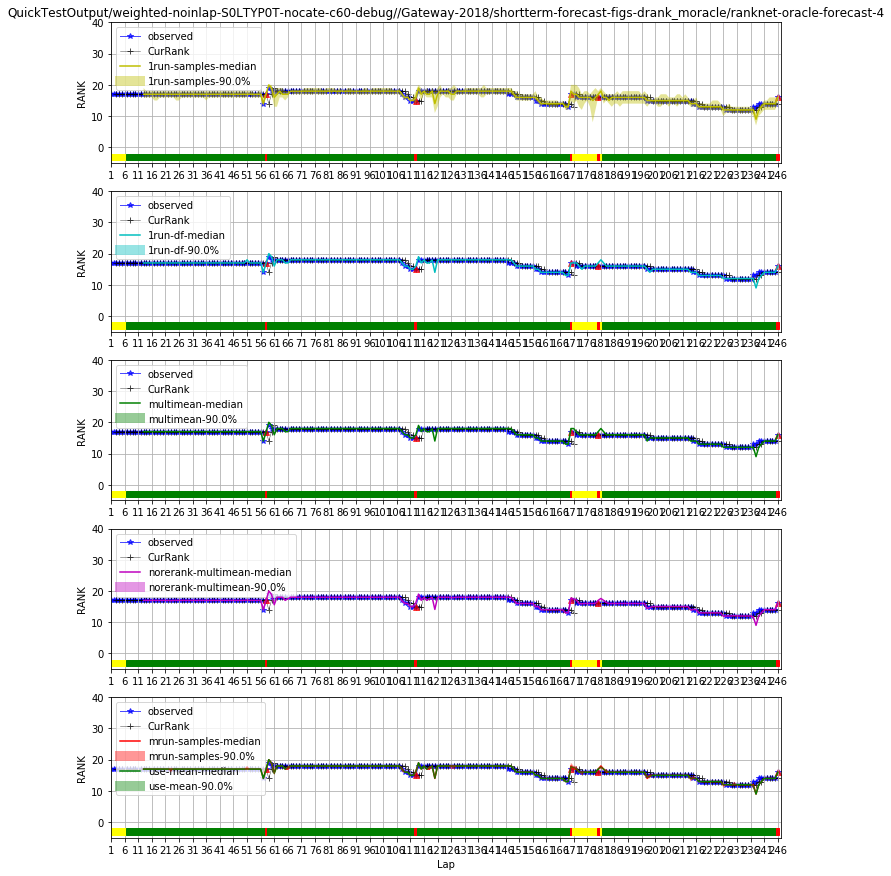

(array([ 58, 119, 180, 225]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)
xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)
xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


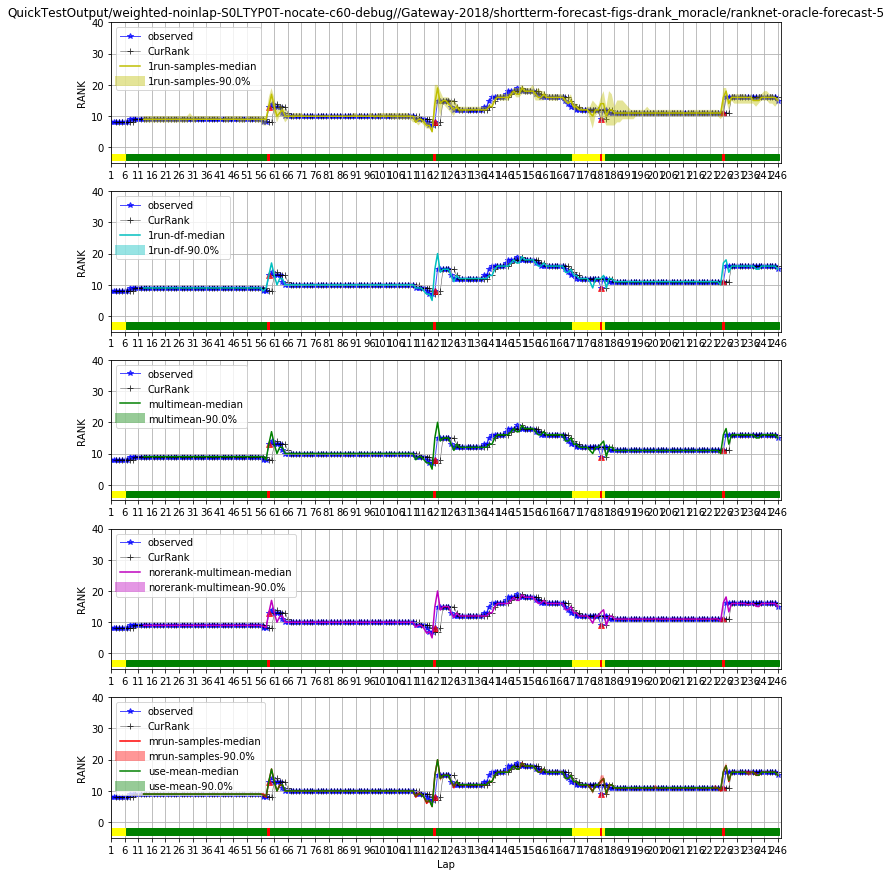

(array([ 60, 122, 176]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


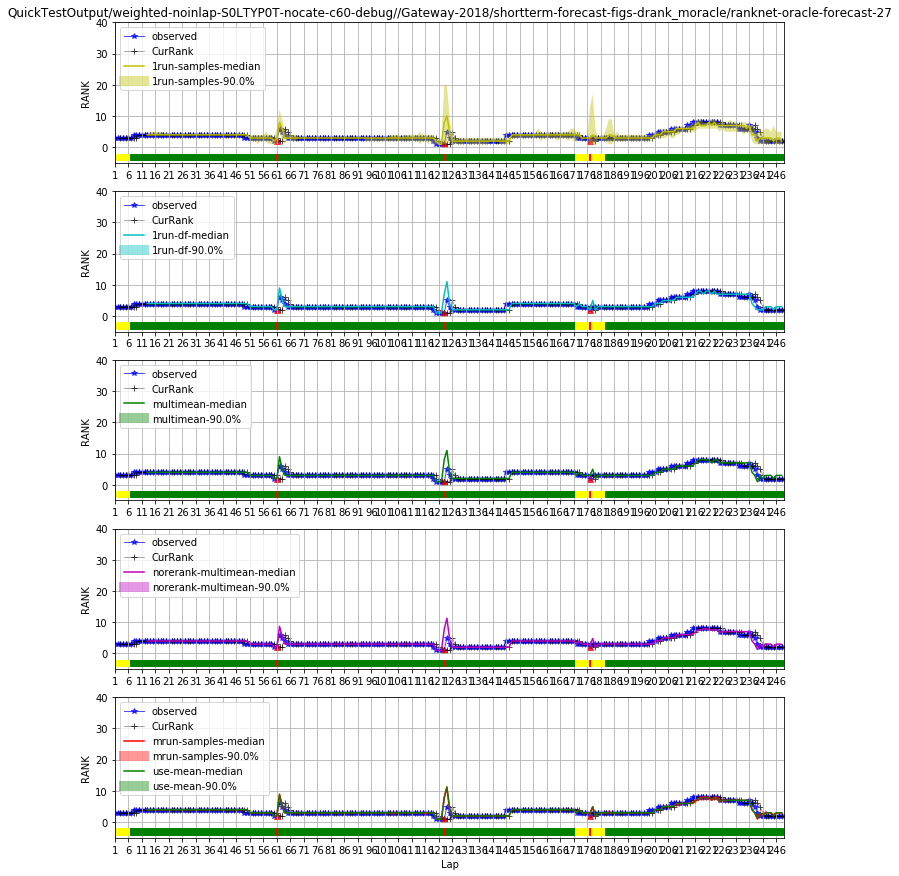

(array([ 59, 119, 176, 237]),)
xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


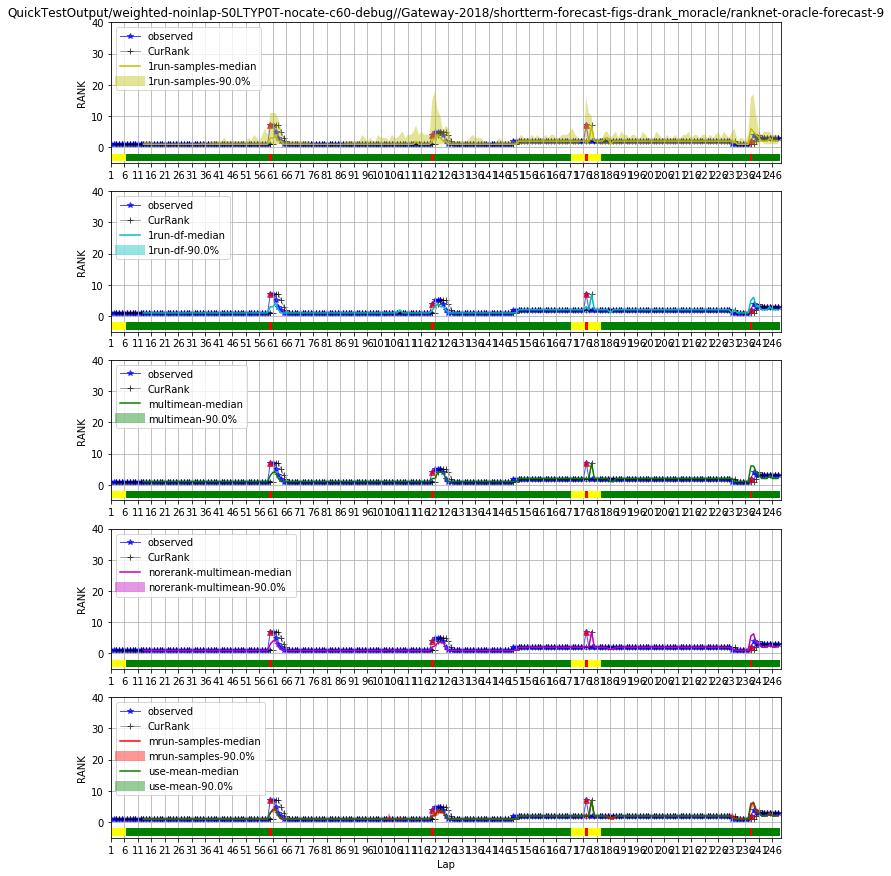

(array([ 60, 118, 176, 224]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


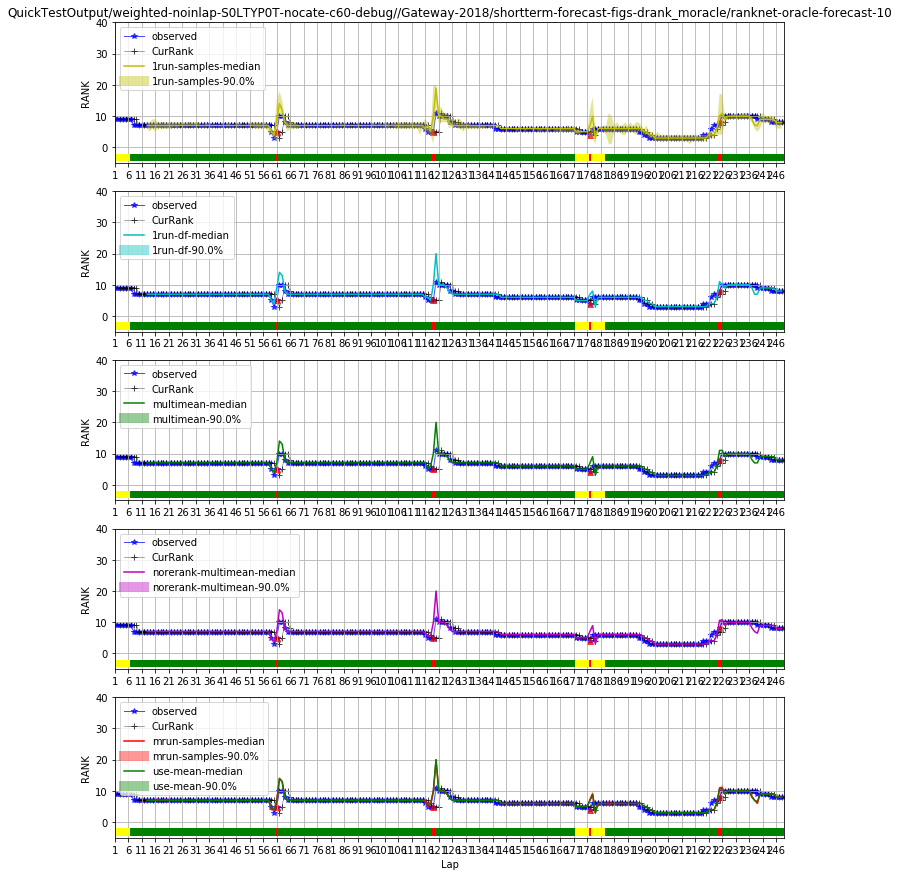

(array([ 61, 119, 176, 230]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


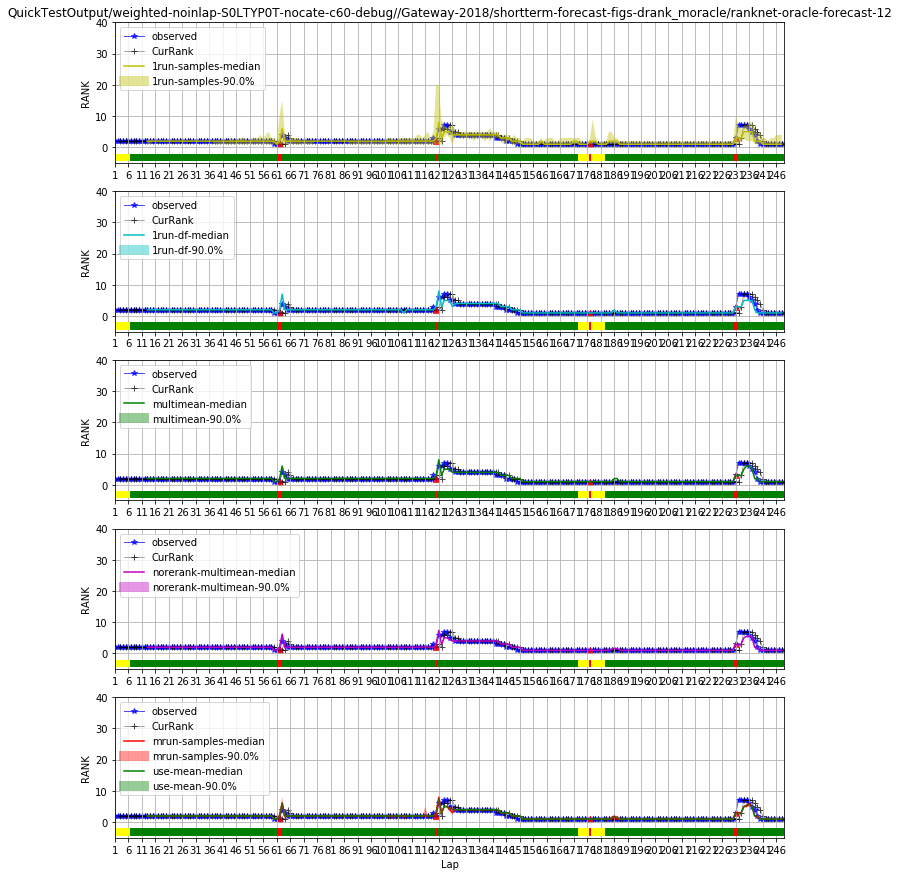

(array([ 56, 110, 157, 216]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


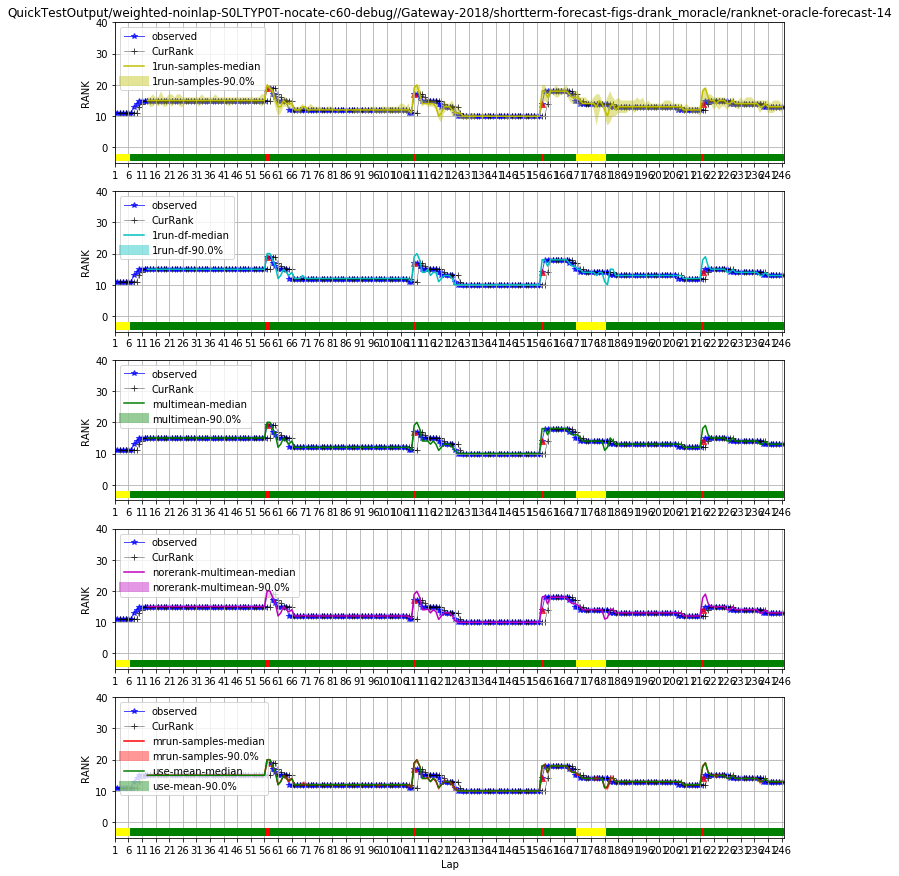

(array([ 62, 124, 180]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


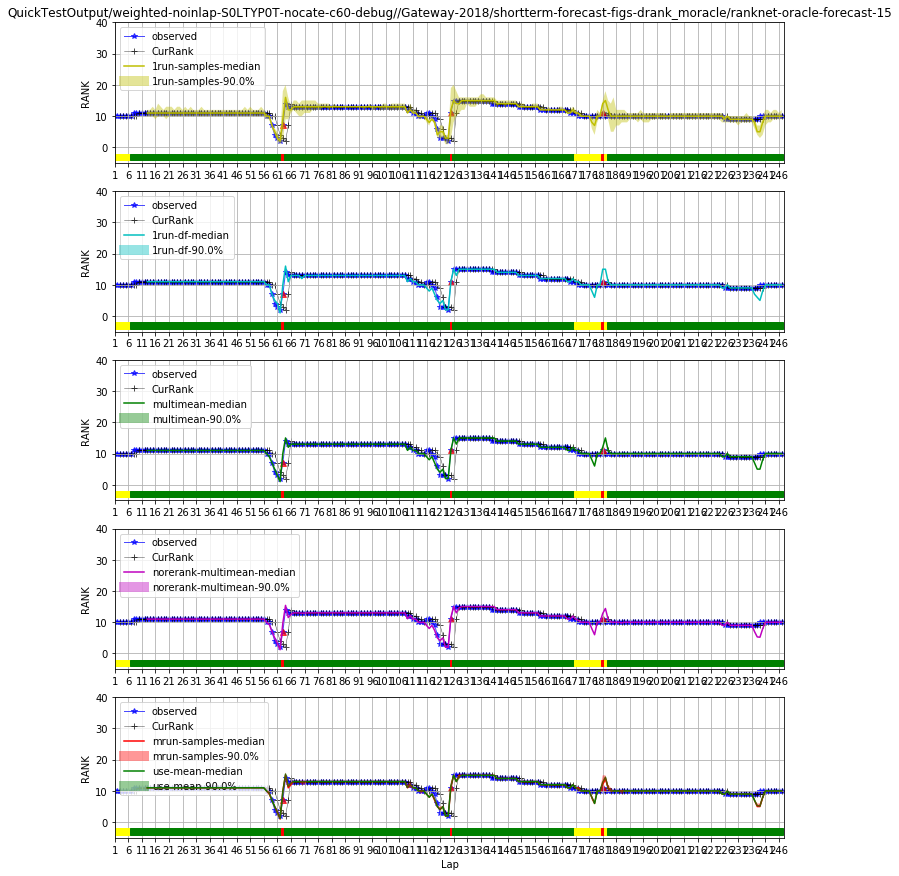

(array([  3,  63, 124, 180]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


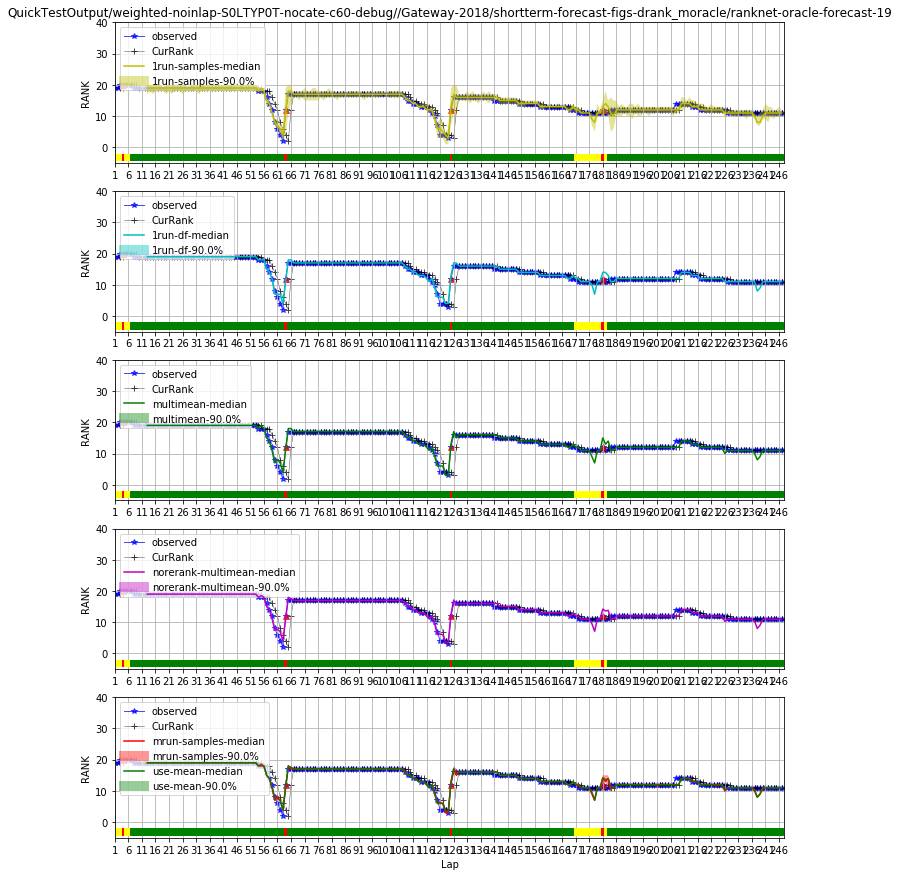

(array([ 58, 107, 149, 197]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)
xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


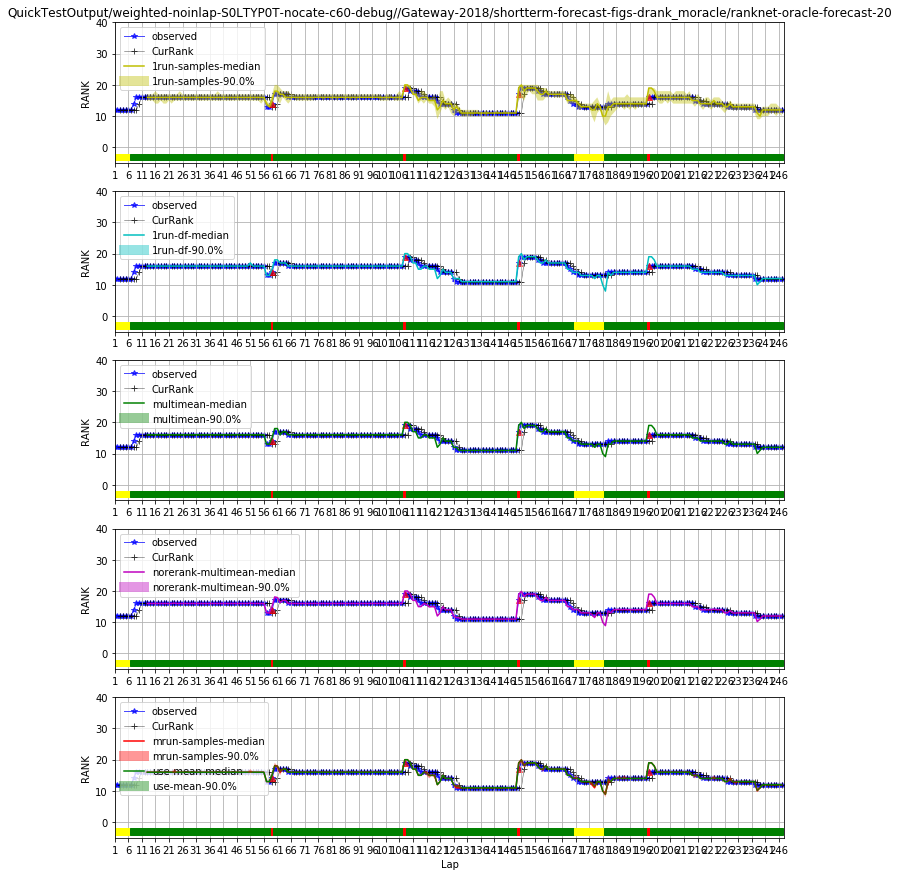

(array([ 59, 118, 180, 236]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


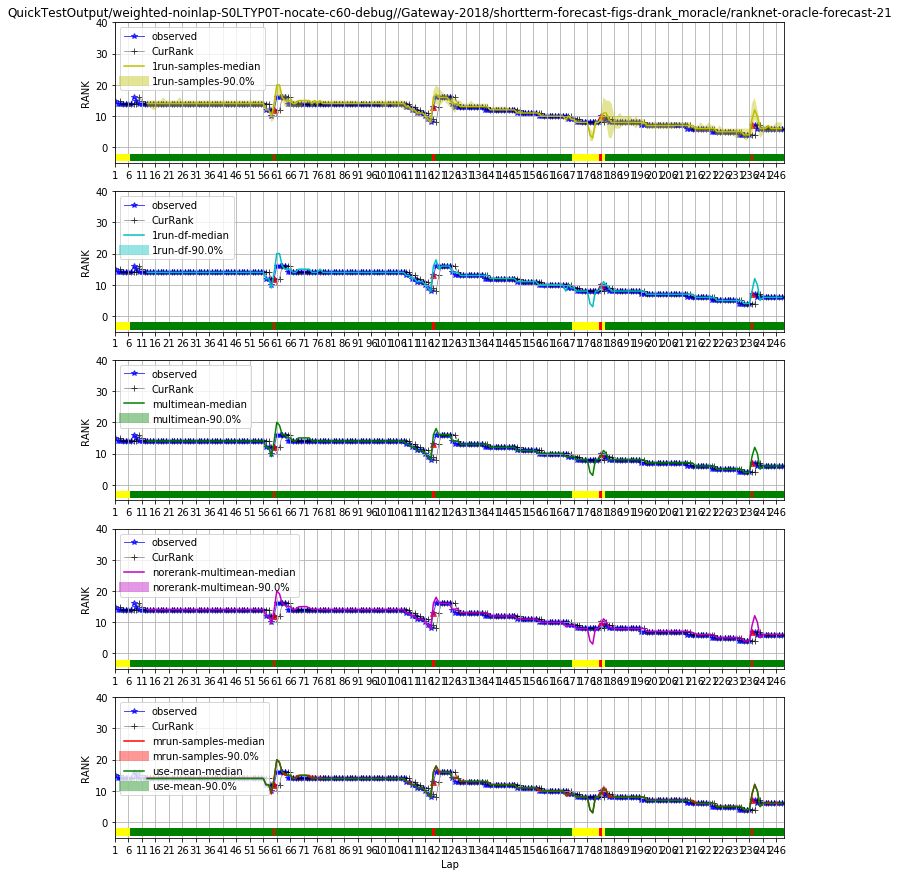

(array([ 59, 116, 176, 236]),)
xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


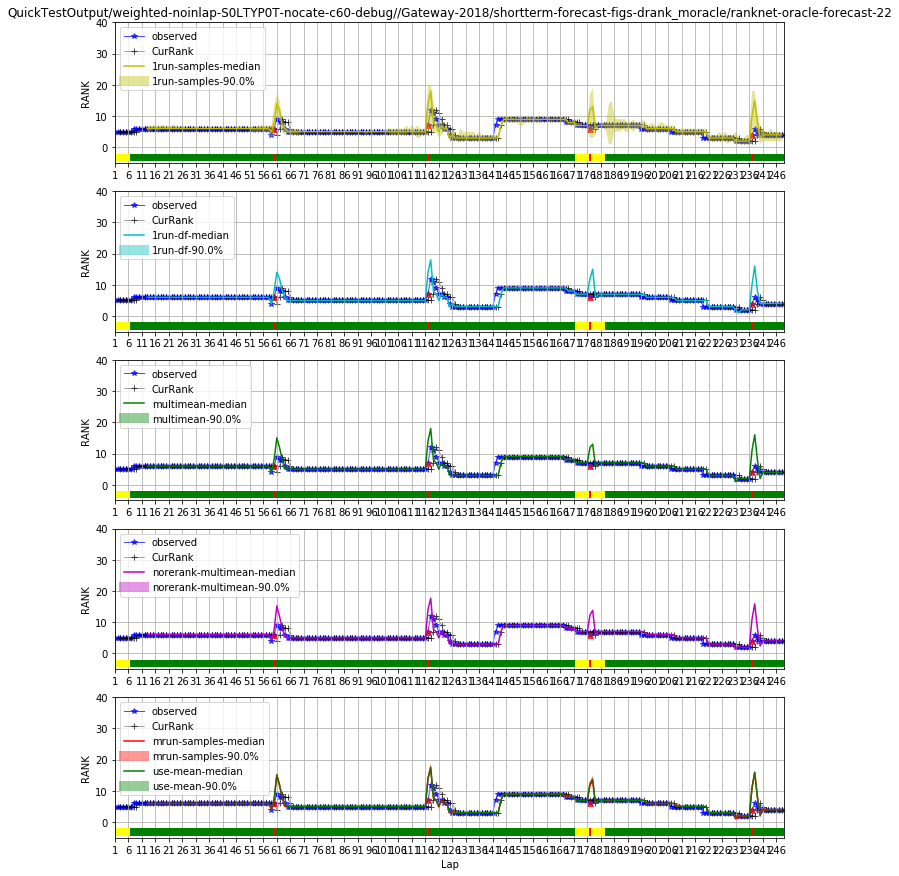

(array([ 53, 104, 156, 161, 169, 226]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


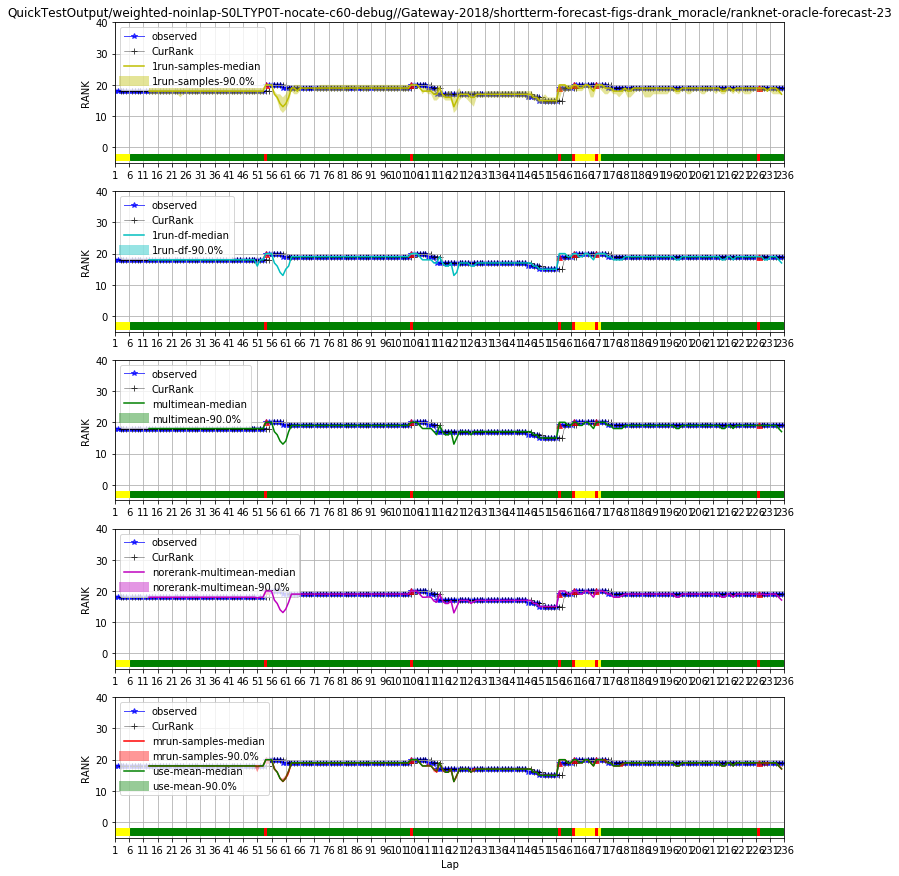

(array([ 56, 108, 110, 163, 175, 227]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


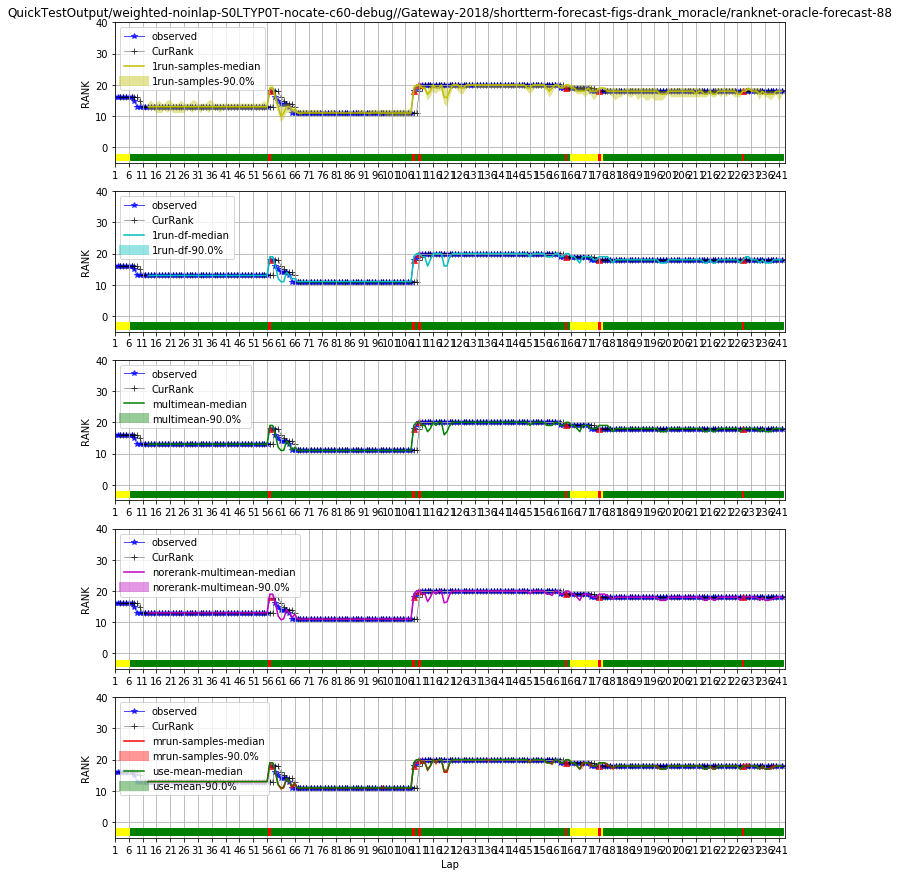

(array([ 59, 118, 176, 238]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


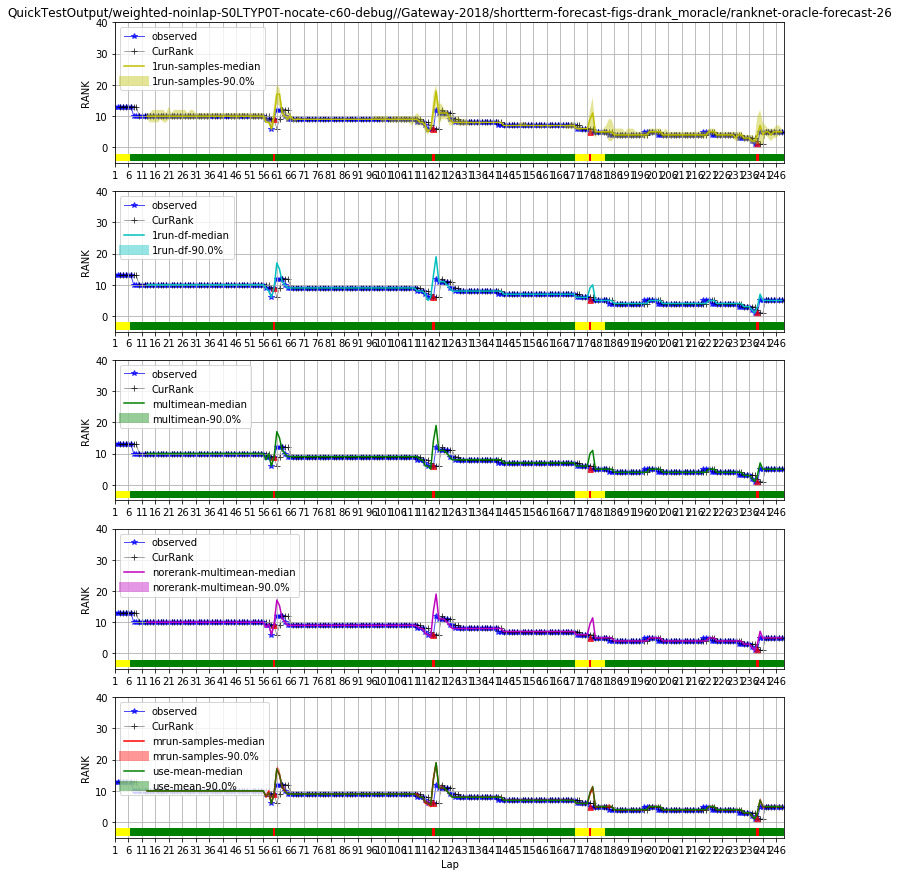

(array([  3,  58, 112, 167, 233]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)
xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


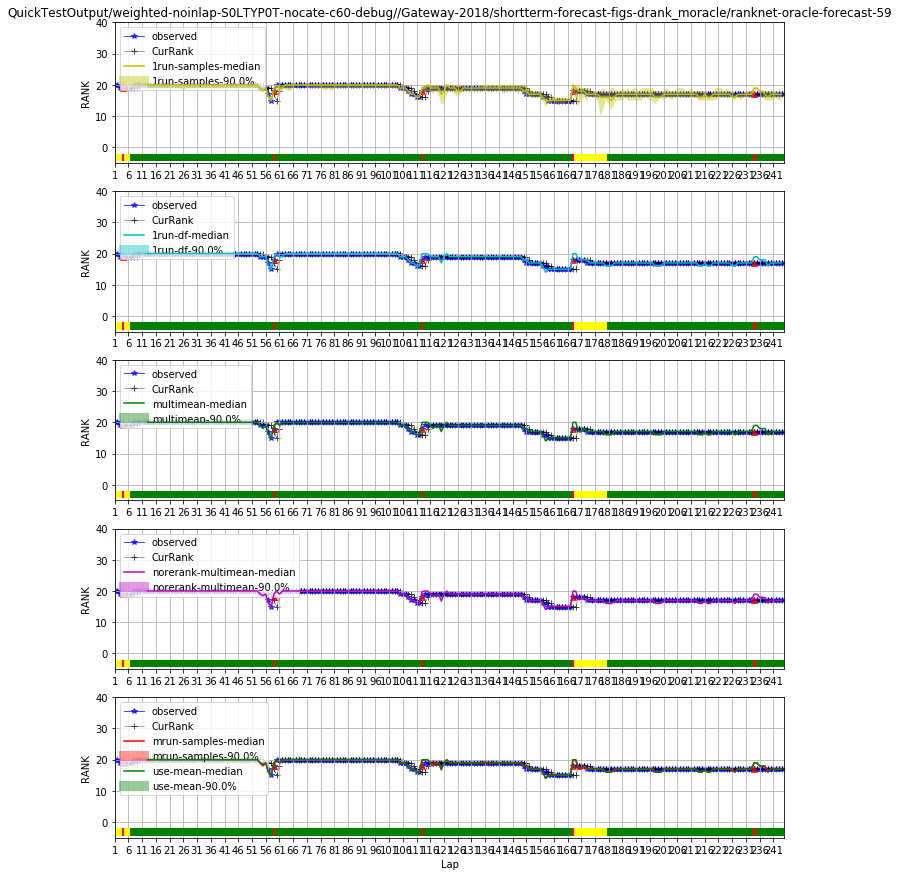

(array([ 58, 115, 171, 172]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


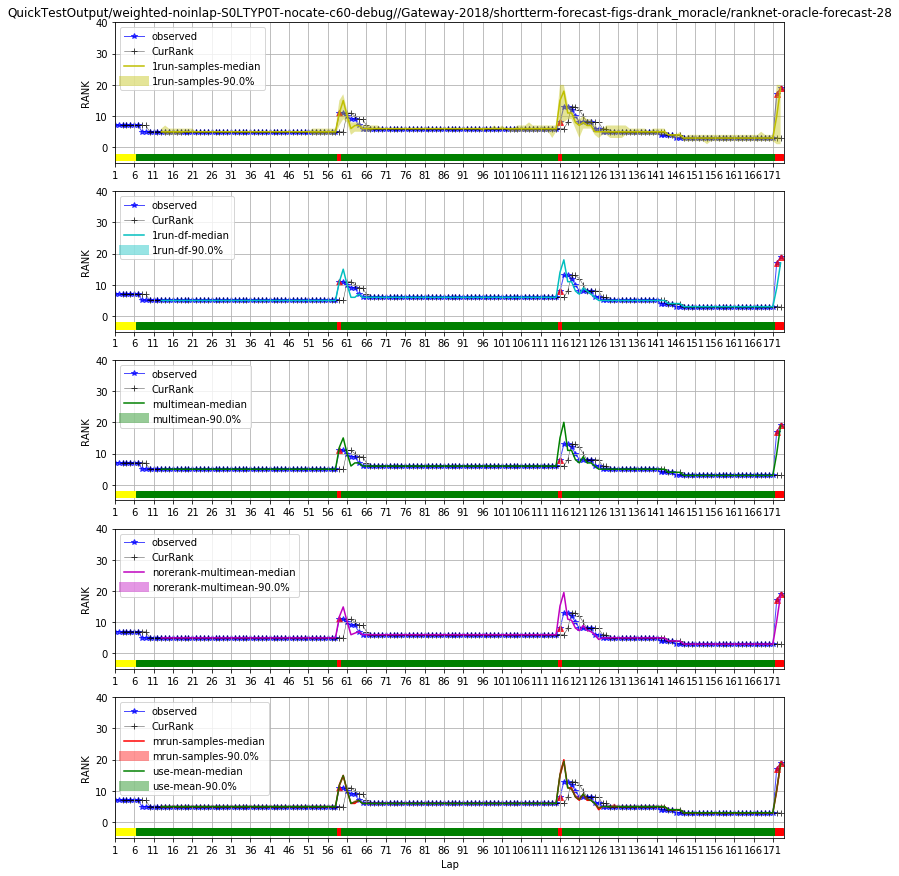

(array([ 63, 125, 180]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)
xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2268: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq='1min') + 2


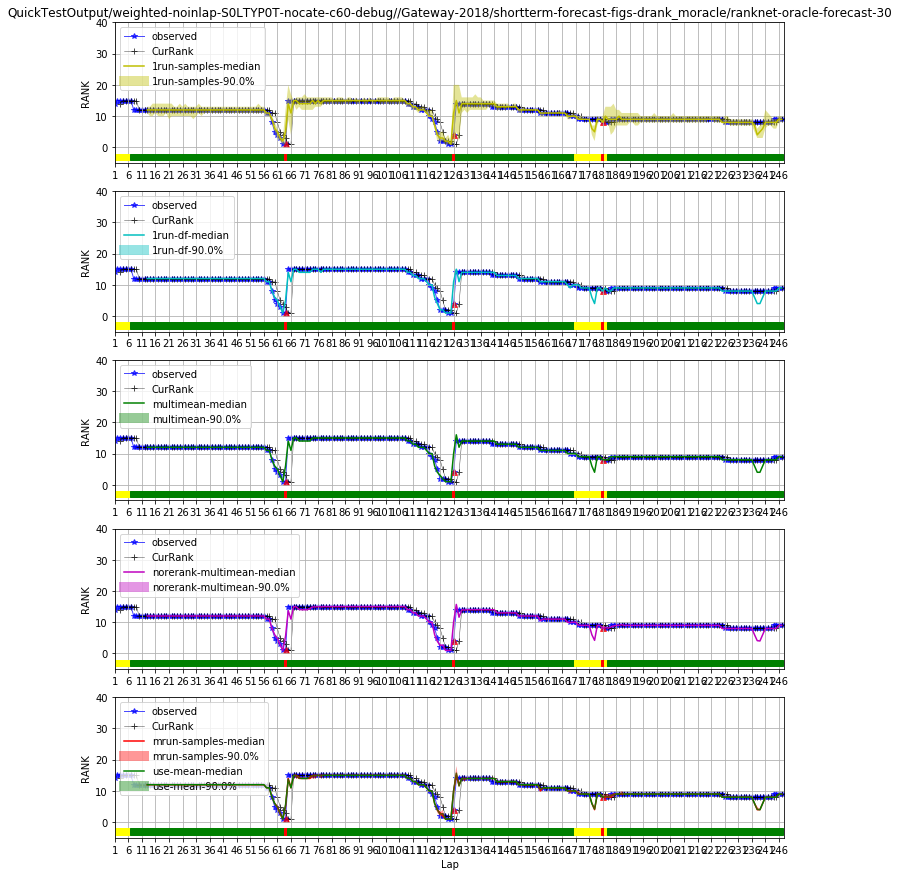

(array([ 58, 119, 176, 237]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2518: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq=gvar.freq) + gvar.prediction_length


xlim: (25771680.0, 25771985.0)
(array([ 56, 112, 167, 213]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2518: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq=gvar.freq) + gvar.prediction_length


xlim: (25771680.0, 25771985.0)
(array([ 57, 112, 169, 179, 245]),)
xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2518: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq=gvar.freq) + gvar.prediction_length


(array([ 58, 119, 180, 225]),)
xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2518: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq=gvar.freq) + gvar.prediction_length


(array([ 60, 122, 176]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2518: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq=gvar.freq) + gvar.prediction_length


xlim: (25771680.0, 25771985.0)
(array([ 59, 119, 176, 237]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2518: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq=gvar.freq) + gvar.prediction_length


xlim: (25771680.0, 25771985.0)
(array([ 60, 118, 176, 224]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2518: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq=gvar.freq) + gvar.prediction_length


xlim: (25771680.0, 25771985.0)
(array([ 61, 119, 176, 230]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2518: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq=gvar.freq) + gvar.prediction_length


xlim: (25771680.0, 25771985.0)
(array([ 56, 110, 157, 216]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2518: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq=gvar.freq) + gvar.prediction_length


xlim: (25771680.0, 25771985.0)
(array([ 62, 124, 180]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2518: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq=gvar.freq) + gvar.prediction_length


xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2518: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq=gvar.freq) + gvar.prediction_length


(array([  3,  63, 124, 180]),)
xlim: (25771680.0, 25771985.0)
(array([ 58, 107, 149, 197]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2518: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq=gvar.freq) + gvar.prediction_length


xlim: (25771680.0, 25771985.0)
(array([ 59, 118, 180, 236]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2518: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq=gvar.freq) + gvar.prediction_length


xlim: (25771680.0, 25771985.0)
(array([ 59, 116, 176, 236]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2518: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq=gvar.freq) + gvar.prediction_length


xlim: (25771680.0, 25771985.0)
(array([ 53, 104, 156, 161, 169, 226]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2518: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq=gvar.freq) + gvar.prediction_length


xlim: (25771680.0, 25771985.0)
(array([ 56, 108, 110, 163, 175, 227]),)
xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2518: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq=gvar.freq) + gvar.prediction_length


(array([ 59, 118, 176, 238]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2518: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq=gvar.freq) + gvar.prediction_length


xlim: (25771680.0, 25771985.0)
(array([  3,  58, 112, 167, 233]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2518: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq=gvar.freq) + gvar.prediction_length


xlim: (25771680.0, 25771985.0)
(array([ 58, 115, 171, 172]),)
xlim: (25771680.0, 25771985.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2518: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq=gvar.freq) + gvar.prediction_length


(array([ 63, 125, 180]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2518: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq=gvar.freq) + gvar.prediction_length


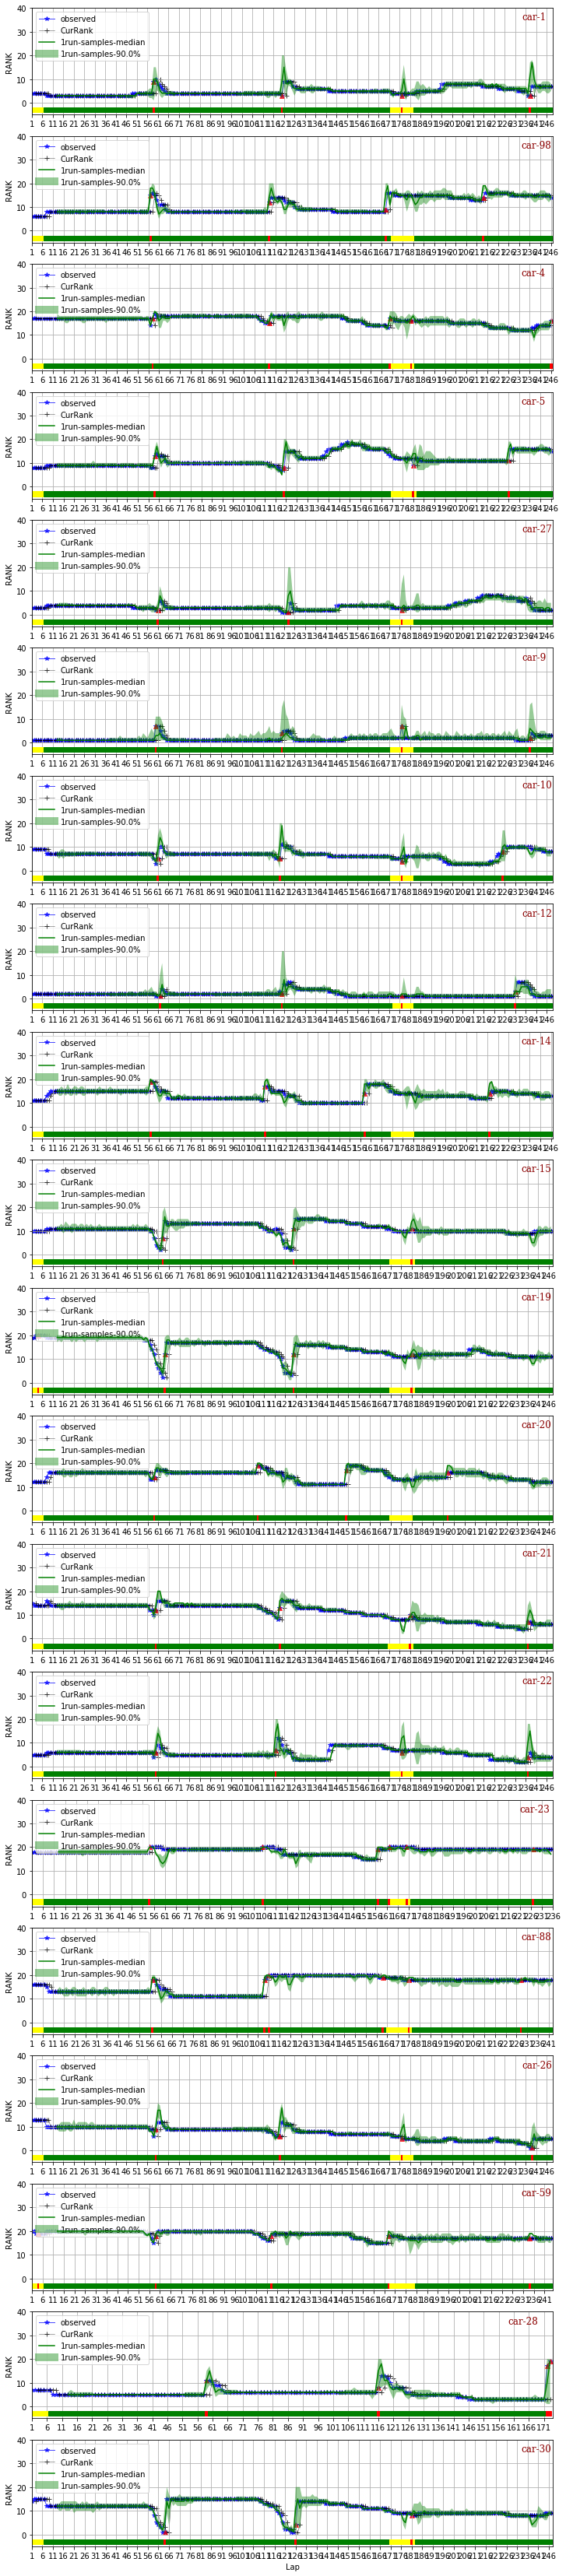

In [13]:
#if False:
    if _forecast_mode == 'shortterm' and _joint_train == False:
        destdir = FORECAST_FIGS_DIR

        if _skip_overwrite and os.path.exists(destdir):
            print('Long Forecasting Figures at:',destdir)

        else:
            with open(STAGE_DATASET, 'rb') as f:
                stagedata = pickle.load(f, encoding='latin1') 
                _alldata, rankdata, _acldata, _flagdata = stagedata[_test_event]

            #set gobal variable
            gvar.rankdata = rankdata
            #destdir = outputRoot + 'oracle-forecast-figs/'
            os.makedirs(destdir, exist_ok=True)

            for carno in alldata:
                plotoracle(alldata, carno, destdir)

            #draw summary result
            outputfile = destdir + f'{configname}'
            plotallcars(alldata, outputfile, drawid = 0)

In [14]:
#plotoracle(alldata, 3)    

In [15]:
outputRoot

'QuickTestOutput/weighted-noinlap-S0LTYP0T-nocate-c60-debug/'

In [16]:
oracle_eval_result

Year   Model                                              ExpID  \
0  Gateway-2018  oracle  weighted-noinlap-S0LTYP0T-nocate-c60-drank-oracle   
1  Gateway-2018  oracle  weighted-noinlap-S0LTYP0T-nocate-c60-drank-oracle   
2  Gateway-2018  oracle  weighted-noinlap-S0LTYP0T-nocate-c60-drank-oracle   

  laptype   Top1Acc       MAE   50-Risk   90-Risk  
0     all  0.961864  0.260738  0.038343  0.032939  
1  normal  0.983333  0.055346  0.017315  0.013406  
2     pit  0.925532  0.560307  0.064081  0.056772

In [18]:
for t in events_info.keys():
    print(t, int(events_info[t][0]/events_info[t][1]))

Phoenix 250
Indy500 200
Texas 248
Iowa 299
Pocono 200
Gateway 248
